# Ants Bees VGG16 による解析

# Fitting 

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pillow==6.2.1

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.9MB 22kB/s 
     |████████████████████████████████| 8.8MB 22.3MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.2.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 2.1MB 18.5MB/s 
ERROR: bokeh 2.3.0 has requirement pillow>=7.1.0, but you'll have pillow 6.2.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data'
root_dir= '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data'

In [ ]:
'''
3. 前処理前後の画像を確認する
'''
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data
from pathlib import Path
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data
from pathlib import Path
import glob
import torchvision
import cv2
import numpy as np
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data
from pathlib import Path
import glob
import torchvision
import cv2
import numpy as np

In [ ]:
'''
2. 前処理クラスの定義
'''
class ImageTransform():
    '''画像の前処理クラス。訓練時、検証時で異なる動作をする。

    Attributes:
      data_transform(dic):
        train: 訓練用のトランスフォーマーオブジェクト
        val  : 検証用のトランスフォーマーオブジェクト
    '''

    def __init__(self, resize, mean, std):
        '''トランスフォーマーオブジェクトを生成する。

        Parameters:
        resize(int): リサイズ先の画像の大きさ
        mean(tuple): (R, G, B)各色チャネルの平均値
        std        : (R, G, B)各色チャネルの標準偏差
        '''
        # dicに訓練用、検証用のトランスフォーマーを生成して格納
        self.data_transform = {
            'train': transforms.Compose([
                # ランダムにトリミングする
                #transforms.RandomResizedCrop(
                #    resize, # トリミング後の出力サイズ
                #    scale=(0.5, 1.0)),  # スケールの変動幅
                #transforms.RandomHorizontalFlip(p = 0.5),  # 0.5の確率で左右反転
                #transforms.RandomRotation(15),  # 15度の範囲でランダムに回転
                transforms.ToTensor(),          # Tensorオブジェクトに変換
                transforms.Normalize(mean, std) # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),      # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeでトリミング
                transforms.ToTensor(),          # テンソルに変換
                transforms.Normalize(mean, std) # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        '''オブジェクト名でコールバックされる
        Parameters:
          img: 画像
          phase(str): 'train'または'val' 前処理のモード
        '''
        return self.data_transform[phase](img) # phaseはdictのキー


### 前処理前後の画像を確認する


In [ ]:
tt='hymenoptera_data/'+'train'+'/bees/2405441001_b06c36fa72.jpg'
image_file_path = os.path.join(data_dir,tt)
print(image_file_path)

/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg


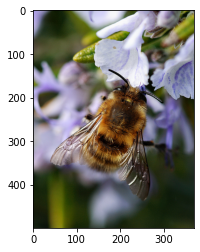

In [ ]:
%matplotlib inline

# サンプル画像を1枚読み込む
image_file_path = os.path.join(data_dir,'hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg')
img = Image.open(image_file_path)   # (高さ, 幅, RGB)

# 元の画像の表示
plt.imshow(img)
plt.show()

In [ ]:


# サンプル画像を1枚読み込む
image_file_path = os.path.join(data_dir,'hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg')
img = Image.open(image_file_path) 
a=np.array(img)
print(np.array(img))
print(a.shape)
print(np.mean(a[:,:,0])) # B
print(np.mean(a[:,:,1])) # G
print(np.mean(a[:,:,2])) # R

[[[176 161 230]
  [174 161 230]
  [172 159 228]
  ...
  [ 98 102  88]
  [ 95 101  73]
  [ 87  96  43]]

 [[178 163 232]
  [174 161 230]
  [172 159 228]
  ...
  [107 114 106]
  [ 98 112  87]
  [ 79  92  38]]

 [[178 165 234]
  [175 162 231]
  [172 159 228]
  ...
  [136 138 133]
  [115 122 106]
  [ 90 102  54]]

 ...

 [[ 22  34  20]
  [ 21  33  19]
  [ 23  35  21]
  ...
  [ 46  55  26]
  [ 46  55  24]
  [ 49  55  27]]

 [[ 22  34  20]
  [ 22  34  20]
  [ 23  35  21]
  ...
  [ 46  55  24]
  [ 46  55  24]
  [ 51  54  25]]

 [[ 23  35  21]
  [ 23  35  21]
  [ 23  36  19]
  ...
  [ 48  55  24]
  [ 48  55  22]
  [ 53  54  23]]]
(500, 369, 3)
106.4428834688347
104.52070460704607
96.60064498644986


In [ ]:
print(((106.4428834688347/255)-0.485)/0.229)
print(((104.52070460704607/255)-0.456)/0.224)
print(((96.60064498644986/255)-0.406)/0.225)

-0.29509575359474793
-0.2058700173836472
-0.12077307213159298


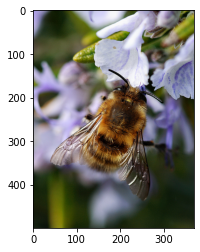

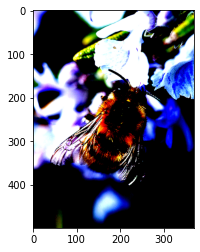

In [ ]:

%matplotlib inline

# サンプル画像を1枚読み込む
image_file_path = os.path.join(data_dir,'hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg')
img = Image.open(image_file_path)   # (高さ, 幅, RGB)

# 元の画像の表示
plt.imshow(img)
plt.show()

# 画像の前処理と処理済み画像の表示
# モデルの入力サイズ(タテ・ヨコ)
SIZE = 224
# 正規化・標準化する際の各RGBの平均値
MEAN = (0.485, 0.456, 0.406) # ImageNetデータセットの正規化・標準化の処理後の平均値を使用
# 正規化・標準化する際の各RGBの標準偏差
STD = (0.229, 0.224, 0.225)  # ImageNetデータセットの正規化・標準化の処理後の標準偏差を使用

# トランスフォーマーオブジェクトを生成
transform = ImageTransform(SIZE, MEAN, STD)
# 訓練モードの前処理を適用、torch.Size([3, 224, 224])
img_transformed = transform(img, phase="train")

# (色、高さ、幅)を (高さ、幅、色)に変換
img_transformed2 = img_transformed.numpy().transpose((1, 2, 0))
# ピクセル値を0～1の範囲に制限して表示
img_transformed3 = np.clip(img_transformed2, 0, 1)
plt.imshow(img_transformed3)
plt.show()

In [ ]:
train_img3=img_transformed.to(torch.float64)
std_mean_r=torch.std_mean(train_img3[0,:,:]) #R
std_mean_g=torch.std_mean(train_img3[1,:,:]) #G
std_mean_b=torch.std_mean(train_img3[2,:,:]) #B
print(std_mean_r)
print(std_mean_g)
print(std_mean_b)

(tensor(1.1012, dtype=torch.float64), tensor(-0.2951, dtype=torch.float64))
(tensor(1.0668, dtype=torch.float64), tensor(-0.2059, dtype=torch.float64))
(tensor(1.4157, dtype=torch.float64), tensor(-0.1208, dtype=torch.float64))


#【結語】

ImageTransformクラスにて、標準化したときには、２５５で割った値を、平均、標準偏差にて標準化した値に変換される。

#Q.E.D